Input Data:
- '../../Clean_Data/Weather_Data/Combined_Weather_Data_w_Veg_SubRegion_Filter/SWE.parquet' (from code 02 05)
- '../../Clean_Data/Fire_Data/Extended_Fire_Data/calfire_fod_fpa_1994_2020_dedup_map_weather_grid.parquet' (from code 01)

Output Data:
- '../../Clean_Data/Fire_Data/Extended_Fire_Data/calfire_fod_fpa_1994_2020_fire_label_w_size.parquet'


In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [3]:
import re

In [4]:
import os
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

In [5]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [9]:
path_to_read = '../../Clean_Data/Weather_Data/Combined_Weather_Data_w_Veg_SubRegion_Filter/'
file = 'wind_speed.parquet'
weather_data = pd.read_parquet(os.path.join(path_to_read, file))

In [10]:
weather_data.dtypes

day           datetime64[ns]
lon                  float64
lat                  float64
wind_speed           float32
year                   int32
dtype: object

In [11]:
weather_data = weather_data[['lon', 'lat', 'day']].drop_duplicates().reset_index(drop=True)

In [12]:
weather_data.shape # this weather data is after inner join with vegetation data and subregion filter

(142966936, 3)

In [13]:
# check if there is any missing value
weather_data.isnull().sum()

lon    0
lat    0
day    0
dtype: int64

In [15]:
input_fire_dir = '../../Clean_Data/Fire_Data/Extended_Fire_Data/'
file_name = 'calfire_fod_fpa_1994_2020_dedup_map_weather_grid.parquet'
fire_data = pd.read_parquet(os.path.join(input_fire_dir, file_name))

In [16]:
fire_data.head()

,LONGITUDE,LATITUDE,DISCOVERY_DATE,CONT_DATE,max_FIRE_SIZE,min_FIRE_SIZE,FOD_ID_cnt,diff_FIRE_SIZE,NEAREST_LAT,NEAREST_LON,DISTANCE_KM
0,-122.315000,41.298889,1995-08-10,1995-08-26,0.1,0.1,91,0.0,41.316667,-122.308333,2.051812
1,-116.834700,32.584800,1996-04-15,1996-04-15,1402.0,0.1,64,1401.9,32.566667,-116.850000,2.471389
2,-116.834700,32.584800,1996-05-17,1996-05-17,0.2,0.1,36,0.1,32.566667,-116.850000,2.471389
3,-117.128889,33.218889,1997-07-22,1997-08-07,80.0,1.0,21,79.0,33.233333,-117.141667,1.996268
4,-116.834700,32.584800,1996-06-10,1996-06-10,0.3,0.3,19,0.0,32.566667,-116.850000,2.471389


In [17]:
fire_data.isnull().mean()

LONGITUDE         0.0
LATITUDE          0.0
DISCOVERY_DATE    0.0
CONT_DATE         0.0
max_FIRE_SIZE     0.0
min_FIRE_SIZE     0.0
FOD_ID_cnt        0.0
diff_FIRE_SIZE    0.0
NEAREST_LAT       0.0
NEAREST_LON       0.0
DISTANCE_KM       0.0
dtype: float64

In [19]:
fire_data.dtypes

LONGITUDE                float64
LATITUDE                 float64
DISCOVERY_DATE    datetime64[ns]
CONT_DATE         datetime64[ns]
max_FIRE_SIZE            float64
min_FIRE_SIZE            float64
FOD_ID_cnt                 int64
diff_FIRE_SIZE           float64
NEAREST_LAT              float64
NEAREST_LON              float64
DISTANCE_KM              float64
dtype: object

In [22]:
# check if there is rows that have CONT_DATE < DISCOVERY_DATE
(fire_data['CONT_DATE'] < fire_data['DISCOVERY_DATE']).sum()

0

In [21]:
columns_to_show = ['LONGITUDE','LATITUDE','DISCOVERY_DATE','CONT_DATE']
fire_data[columns_to_show].duplicated().sum()

0

In [20]:
columns_to_show = ['NEAREST_LON','NEAREST_LAT','DISCOVERY_DATE','CONT_DATE']
fire_data[columns_to_show].duplicated().sum()

3280

this means some fire events which happen to be in the same dates and are pretty close so being matched to the same weather grid.

## Dedup

In [23]:
print(f"before deduplication, the shape of fire data is {fire_data.shape}")

column_to_group = ['NEAREST_LON','NEAREST_LAT','DISCOVERY_DATE','CONT_DATE']
# group by ['NEAREST_LON','NEAREST_LAT','DISCOVERY_DATE','CONT_DATE'], and get min of column 'min_FIRE_SIZE', max of column 'max_FIRE_SIZE'
fire_data = fire_data.groupby(column_to_group).agg({'min_FIRE_SIZE': 'min', 'max_FIRE_SIZE': 'max'}).reset_index()

print(f"after deduplication, the shape of fire data is {fire_data.shape}")

before deduplication, the shape of fire data is (164506, 11)
after deduplication, the shape of fire data is (161226, 6)


In [25]:
fire_data = fire_data.rename(columns={'NEAREST_LON': 'lon', 'NEAREST_LAT': 'lat'})

In [26]:
fire_data.head()

,lon,lat,DISCOVERY_DATE,CONT_DATE,min_FIRE_SIZE,max_FIRE_SIZE
0,-124.391667,40.400000,2007-07-14,2007-07-14,0.1,0.1
1,-124.391667,40.441667,1998-10-05,1998-10-21,7.0,7.0
2,-124.391667,40.441667,2001-07-17,2001-07-17,0.1,0.1
3,-124.391667,40.441667,2005-09-24,2005-09-24,0.1,0.1
4,-124.391667,40.441667,2012-10-20,2012-11-05,0.1,0.1


## Assign Fire Label to each grid on each day

For each location, for days
- DISCOVERY_DATE date -4, DISCOVERY_DATE date -1: remove
- DISCOVERY_DATE date: label 1
- DISCOVERY_DATE date - cont date: remove

In [27]:
# check if there is any duplicate
fire_data.duplicated().sum()

0

In [28]:
fire_data.dtypes

lon                      float64
lat                      float64
DISCOVERY_DATE    datetime64[ns]
CONT_DATE         datetime64[ns]
min_FIRE_SIZE            float64
max_FIRE_SIZE            float64
dtype: object

In [29]:
fire_data.shape

(161226, 6)

In [30]:
# Function to expand each row
def expand_dates(row):
    start_date = row['DISCOVERY_DATE'] - pd.Timedelta(days=4)
    end_date = row['CONT_DATE']
    date_range = pd.date_range(start=start_date, end=end_date)
    return pd.DataFrame({
        'lon': row['lon'],
        'lat': row['lat'],
        'min_FIRE_SIZE': row['min_FIRE_SIZE'],
        'max_FIRE_SIZE': row['max_FIRE_SIZE'],
        'DATE': date_range,
        'IS_DISCOVERY_DATE': date_range == row['DISCOVERY_DATE']
    })

# Apply the function to each row and concatenate the results
expanded_fire_data = pd.concat(fire_data.apply(expand_dates, axis=1).to_list(), ignore_index=True)

In [35]:
fire_data.head(3)

,lon,lat,DISCOVERY_DATE,CONT_DATE,min_FIRE_SIZE,max_FIRE_SIZE
0,-124.391667,40.400000,2007-07-14,2007-07-14,0.1,0.1
1,-124.391667,40.441667,1998-10-05,1998-10-21,7.0,7.0
2,-124.391667,40.441667,2001-07-17,2001-07-17,0.1,0.1


In [34]:
# check row 1: row 6
expanded_fire_data.head(27)

,lon,lat,min_FIRE_SIZE,max_FIRE_SIZE,DATE,IS_DISCOVERY_DATE
0,-124.391667,40.400000,0.1,0.1,2007-07-10,False
1,-124.391667,40.400000,0.1,0.1,2007-07-11,False
2,-124.391667,40.400000,0.1,0.1,2007-07-12,False
3,-124.391667,40.400000,0.1,0.1,2007-07-13,False
4,-124.391667,40.400000,0.1,0.1,2007-07-14,True
5,-124.391667,40.441667,7.0,7.0,1998-10-01,False
6,-124.391667,40.441667,7.0,7.0,1998-10-02,False
7,-124.391667,40.441667,7.0,7.0,1998-10-03,False
8,-124.391667,40.441667,7.0,7.0,1998-10-04,False
9,-124.391667,40.441667,7.0,7.0,1998-10-05,True


In [36]:
expanded_fire_data.shape

(1978630, 6)

In [37]:
expanded_fire_data.head(3)

,lon,lat,min_FIRE_SIZE,max_FIRE_SIZE,DATE,IS_DISCOVERY_DATE
0,-124.391667,40.4,0.1,0.1,2007-07-10,False
1,-124.391667,40.4,0.1,0.1,2007-07-11,False
2,-124.391667,40.4,0.1,0.1,2007-07-12,False


In [ ]:
# further dedup, even if some fire event have different end date, as long as they have the same lon, lat, and start date, we can consider them as the same event
expanded_fire_data = expanded_fire_data.groupby(['lon', 'lat', 'DATE']).agg(
    IS_DISCOVERY_DATE=('IS_DISCOVERY_DATE', 'any'),
    min_FIRE_SIZE=('min_FIRE_SIZE', 'min'),
    max_FIRE_SIZE=('max_FIRE_SIZE', 'max')
).reset_index()

In [39]:
expanded_fire_data.shape

(1789496, 6)

In [40]:
# check if there is any missing value
expanded_fire_data.isnull().sum()

lon                  0
lat                  0
DATE                 0
IS_DISCOVERY_DATE    0
min_FIRE_SIZE        0
max_FIRE_SIZE        0
dtype: int64

In [41]:
# check if there is any duplicate  
expanded_fire_data.duplicated().sum()

0

In [42]:
expanded_fire_data = expanded_fire_data.rename(columns={'DATE': 'day'})

In [43]:
# freq table of IS_ALARM_DATE
expanded_fire_data['IS_DISCOVERY_DATE'].value_counts()

IS_DISCOVERY_DATE
False    1629185
True      160311
Name: count, dtype: int64

In [45]:
expanded_fire_data.dtypes

lon                         float64
lat                         float64
day                  datetime64[ns]
IS_DISCOVERY_DATE              bool
min_FIRE_SIZE               float64
max_FIRE_SIZE               float64
dtype: object

#### pre-investigation on why # of fire event decreased by half after joining w weather grid

In [ ]:
fire_data_location = expanded_fire_data.merge(
    weather_data,
    on=['lon', 'lat', 'day'],
    how='left',
    indicator='in_weather_data'
)

fire_data_location['in_weather_data'] = fire_data_location['in_weather_data'] == 'both'

fire_data_location = fire_data_location.groupby(['lon', 'lat']).agg({
    'in_weather_data': 'any',
}).reset_index()

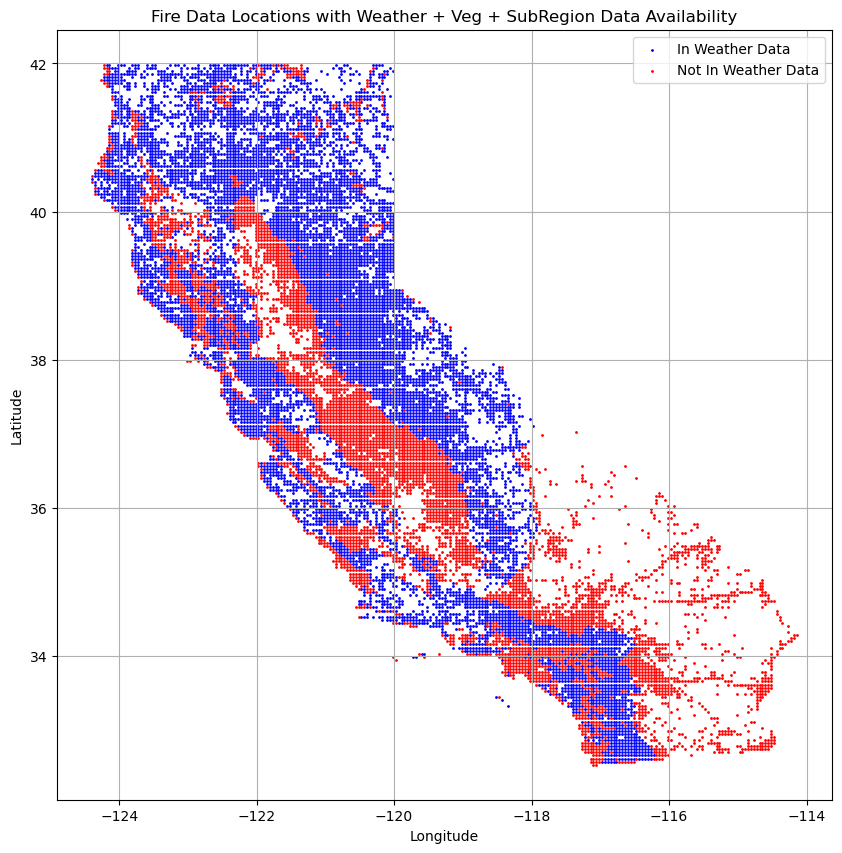

In [61]:
# plot a map to show lon, lat with in_weather_data True
plt.figure(figsize=(10, 10))
plt.scatter(
    fire_data_location[fire_data_location['in_weather_data']]['lon'],
    fire_data_location[fire_data_location['in_weather_data']]['lat'],
    c='blue',
    s=1,
    label='In Weather Data'
)
plt.scatter(
    fire_data_location[~fire_data_location['in_weather_data']]['lon'],
    fire_data_location[~fire_data_location['in_weather_data']]['lat'],
    c='red',
    s=1,
    label='Not In Weather Data'
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fire Data Locations with Weather + Veg + SubRegion Data Availability')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
fire_data_location['in_weather_data'].value_counts()

in_weather_data
True     9049
False    5419
Name: count, dtype: int64

#### Merge

In [46]:
print(f'weather_data has {weather_data.shape[0]} rows and {weather_data.shape[1]} columns before merging')
weather_data = weather_data.merge(expanded_fire_data, on=['lon', 'lat', 'day'], how='left')
print(f'weather_data has {weather_data.shape[0]} rows and {weather_data.shape[1]} columns after merging')

weather_data has 142966936 rows and 3 columns before merging
weather_data has 142966936 rows and 6 columns after merging


In [62]:
weather_data['IS_DISCOVERY_DATE'].value_counts()

IS_DISCOVERY_DATE
False    846085
True      92000
Name: count, dtype: int64

In [63]:
# remove rows when IS_DISCOVERY_DATE is False bc we are not sure if there is a fire event on that day
print(f'weather_data has {weather_data.shape[0]} rows before removing IS_DISCOVERY_DATE is False')
# only keep rows when IS_DISCOVERY_DATE is True or NA
weather_data = weather_data[weather_data['IS_DISCOVERY_DATE'].isna() | weather_data['IS_DISCOVERY_DATE']]
print(f'weather_data has {weather_data.shape[0]} rows after removing IS_DISCOVERY_DATE is False')

weather_data has 142966936 rows before removing IS_DISCOVERY_DATE is False
weather_data has 142120851 rows after removing IS_DISCOVERY_DATE is False


In [66]:
142966936-142120851 

846085

In [64]:
# check IS_ALARM_DATE freq table
weather_data['IS_DISCOVERY_DATE'].value_counts()

IS_DISCOVERY_DATE
True    92000
Name: count, dtype: int64

In [67]:
# if IS_ALARM_DATE is NA, fill it with 0, else fill it with 1
weather_data['IS_DISCOVERY_DATE'] = weather_data['IS_DISCOVERY_DATE'].fillna(0).astype(int)

In [68]:
# rename IS_ALARM_DATE to IS_FIRE
weather_data = weather_data.rename(columns={'IS_DISCOVERY_DATE': 'IS_FIRE'})

In [69]:
weather_data['IS_FIRE'].value_counts()

IS_FIRE
0    142028851
1        92000
Name: count, dtype: int64

In [71]:
92000*100/weather_data.shape[0] # fire event %: 0.065%

0.06473363996392056

In [73]:
# check day range
weather_data['day'].min(), weather_data['day'].max()

(Timestamp('1994-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [74]:
# print current shape before filtering dates
print(f'weather_data has {weather_data.shape[0]} rows before filtering dates')
weather_data = weather_data[weather_data['day'] <= '2020-12-31']
print(f'weather_data has {weather_data.shape[0]} rows after filtering dates')

weather_data has 142120851 rows before filtering dates
weather_data has 127833607 rows after filtering dates


In [75]:
# check day range
weather_data['day'].min(), weather_data['day'].max()

(Timestamp('1994-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [76]:
weather_data.head()

,lon,lat,day,IS_FIRE,min_FIRE_SIZE,max_FIRE_SIZE
0,-124.391667,40.441667,1994-01-01,0,NaN,NaN
1,-124.391667,40.441667,1994-01-02,0,NaN,NaN
2,-124.391667,40.441667,1994-01-03,0,NaN,NaN
3,-124.391667,40.441667,1994-01-04,0,NaN,NaN
4,-124.391667,40.441667,1994-01-05,0,NaN,NaN


In [77]:
# fill NA with 0 for column min_FIRE_SIZE and max_FIRE_SIZE
weather_data['min_FIRE_SIZE'] = weather_data['min_FIRE_SIZE'].fillna(0)
weather_data['max_FIRE_SIZE'] = weather_data['max_FIRE_SIZE'].fillna(0)

In [78]:
# check the sum of min_FIRE_SIZE and max_FIRE_SIZE grouped by IS_FIRE
weather_data.groupby('IS_FIRE').agg({'min_FIRE_SIZE': 'sum', 'max_FIRE_SIZE': 'sum'})

,min_FIRE_SIZE,max_FIRE_SIZE
IS_FIRE,,
0,0.000,0.000
1,8718974.062,9411871.792


In [79]:
input_fire_dir = '../../Clean_Data/Fire_Data/Extended_Fire_Data/'
file_name = 'calfire_fod_fpa_1994_2020_fire_label.parquet'
weather_data.to_parquet(os.path.join(input_fire_dir, file_name), index=False)